
![](https://i.abcnewsfe.com/a/177c862a-4c10-4aca-8e31-872a6c09b81d/8-california-floods-sh-rc-230113_1673622520386_hpEmbed_3x2.jpg)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>1 |</span></b> <b>INTRODUCTION</b></div>

### <b><span style='color:#FFCE30'> 1.1 |</span> Objective</b>

**Objective:** The goal of this competition is to predict the probability of a region flooding based on various factors.

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>2 |</span></b> <b>LOAD LIBRARIES AND DATASET</b></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

from sklearn.ensemble import VotingRegressor

import optuna


from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from termcolor import colored  # for colored output


2024-05-08 09:45:08.754296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:45:08.754393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:45:08.891626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### <b><span style='color:#FFCE30'> 2.1 |</span> Config</b>

In [2]:
palette = ['#20B2AA', '#D8BFD8', '#8B0000', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

config = {
    'SEED' : 42,
    'N_SPLITS': 5,
    'SUBMIT' : True,
    'USE_ORIGINAL': False
    
}

In [3]:
#Load the data
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv',index_col = 'id')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv', index_col = 'id')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

In [4]:
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>DATA DICTIONARY</b></div>

| Column Name                     | Description                                                                                                                   |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------|
| id                             | A unique identifier for each data point.                                                                                      |
| MonsoonIntensity               | Refers to the strength or intensity of the monsoon season in the region.                                                      |
| TopographyDrainage             | Describes the natural drainage characteristics of the region's topography.                                                     |
| RiverManagement                | Indicates the quality and effectiveness of management practices related to rivers in the region.                             |
| Deforestation                  | Represents the extent to which forest cover has been removed or reduced in the region.                                         |
| Urbanization                   | Measures the degree of urban development and expansion in the area.                                                            |
| ClimateChange                  | Reflects the impact of long-term shifts in climate patterns on flood probability.                                              |
| DamsQuality                    | Evaluates the condition and effectiveness of dams and reservoirs in the region.                                                |
| Siltation                      | Refers to the accumulation of sediments or silt in water bodies, rivers, or drainage channels.                                |
| AgriculturalPractices          | Describes the agricultural methods employed in the region and their potential influence on flood susceptibility.              |
| Encroachments                  | Indicates the extent of unauthorized or illegal occupation of land in flood-prone areas.                                      |
| IneffectiveDisasterPreparedness| Assesses the readiness and effectiveness of disaster preparedness measures.                                                     |
| DrainageSystems                | Represents the condition and capacity of artificial drainage systems.                                                          |
| CoastalVulnerability           | Measures the susceptibility of coastal areas to flooding or storm surges.                                                      |
| Landslides                     | Indicates the likelihood and frequency of landslides in the region.                                                            |
| Watersheds                     | Refers to the geographical area drained by a river or body of water.                                                           |
| DeterioratingInfrastructure   | Reflects the condition and maintenance of critical infrastructure.                                                             |
| PopulationScore                | Represents the density and distribution of human population in the region.                                                     |
| WetlandLoss                    | Describes the extent of wetland loss or degradation in the area.                                                               |
| InadequatePlanning             | Indicates deficiencies in urban or regional planning processes related to flood risk management.                              |
| PoliticalFactors               | Considers political decisions, policies, or governance structures related to flood risk mitigation efforts.                  |
| FloodProbability (Target)      | The variable to be predicted, representing the probability of flooding in the region, ranging from 0 to 1.                    |


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>4 |</span></b> <b>DATA CHECKS STEPS</b></div>

### <b><span style='color:#FFCE30'> 4.1 |</span> Check Missing Values</b>

In [5]:
train.isna().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

### <b><span style='color:#FFCE30'> 4.2 |</span> Check Duplicates</b>

In [6]:
train.duplicated().sum()

0

### <b><span style='color:#FFCE30'> 4.3 |</span> Check Data Types</b>

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

### <b><span style='color:#FFCE30'> 4.4 |</span> Check unique values per column</b>

In [8]:
train.nunique()

MonsoonIntensity                   17
TopographyDrainage                 19
RiverManagement                    17
Deforestation                      18
Urbanization                       18
ClimateChange                      18
DamsQuality                        17
Siltation                          17
AgriculturalPractices              17
Encroachments                      19
IneffectiveDisasterPreparedness    17
DrainageSystems                    18
CoastalVulnerability               18
Landslides                         17
Watersheds                         17
DeterioratingInfrastructure        18
PopulationScore                    19
WetlandLoss                        20
InadequatePlanning                 17
PoliticalFactors                   17
FloodProbability                   83
dtype: int64

### <b><span style='color:#FFCE30'> 4.5 |</span> Check statistics of data</b>

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1117957.0,4.921450,2.056387,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1117957.0,4.926671,2.093879,0.000,3.00,5.000,6.00,18.000
RiverManagement,1117957.0,4.955322,2.072186,0.000,4.00,5.000,6.00,16.000
Deforestation,1117957.0,4.942240,2.051689,0.000,4.00,5.000,6.00,17.000
Urbanization,1117957.0,4.942517,2.083391,0.000,3.00,5.000,6.00,17.000
ClimateChange,1117957.0,4.934093,2.057742,0.000,3.00,5.000,6.00,17.000
DamsQuality,1117957.0,4.955878,2.083063,0.000,4.00,5.000,6.00,16.000
Siltation,1117957.0,4.927791,2.065992,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1117957.0,4.942619,2.068545,0.000,3.00,5.000,6.00,16.000
Encroachments,1117957.0,4.949230,2.083324,0.000,4.00,5.000,6.00,18.000


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>EDA</b></div>

### <b><span style='color:#FFCE30'>5.1 |</span> Monsoon Intensity</b>

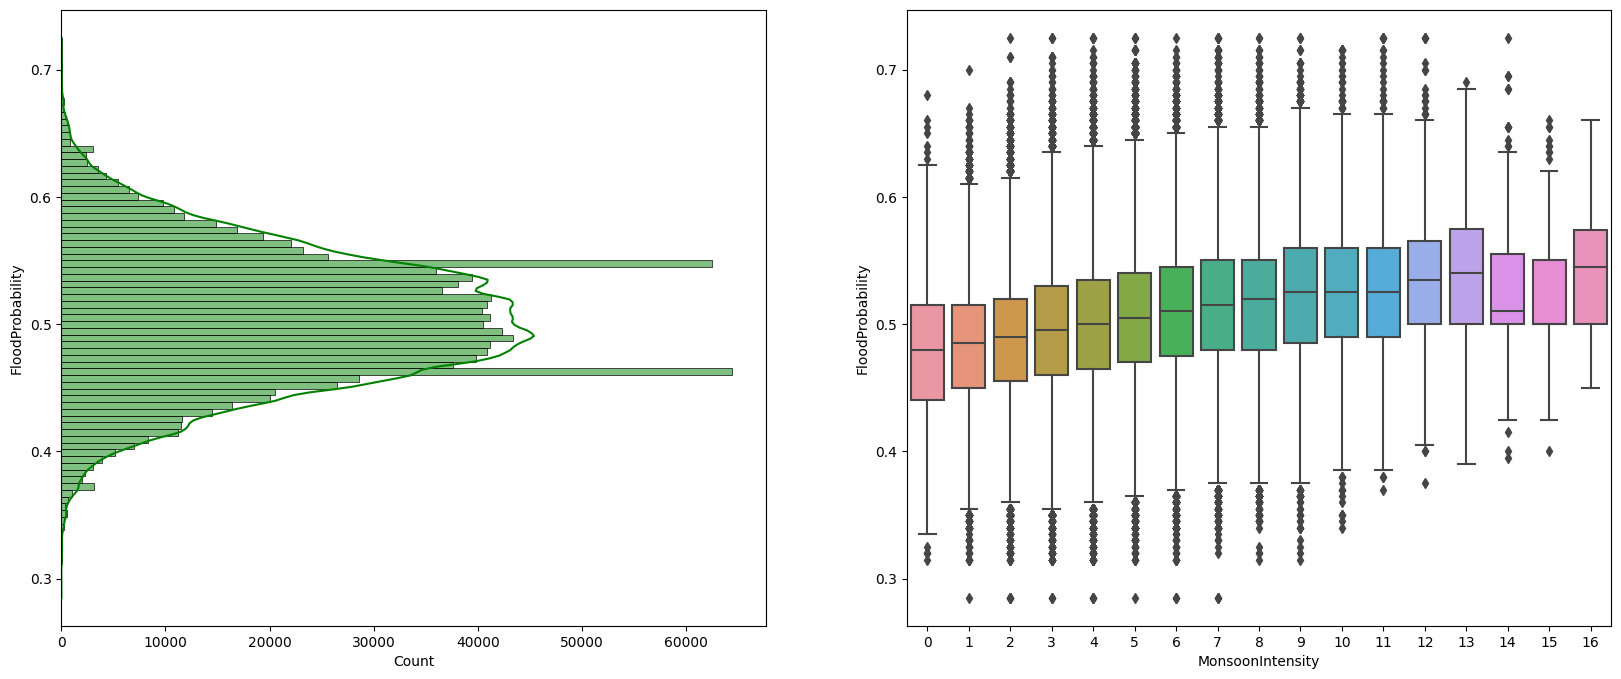

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='MonsoonIntensity', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.2 |</span> Topography Drainage</b>

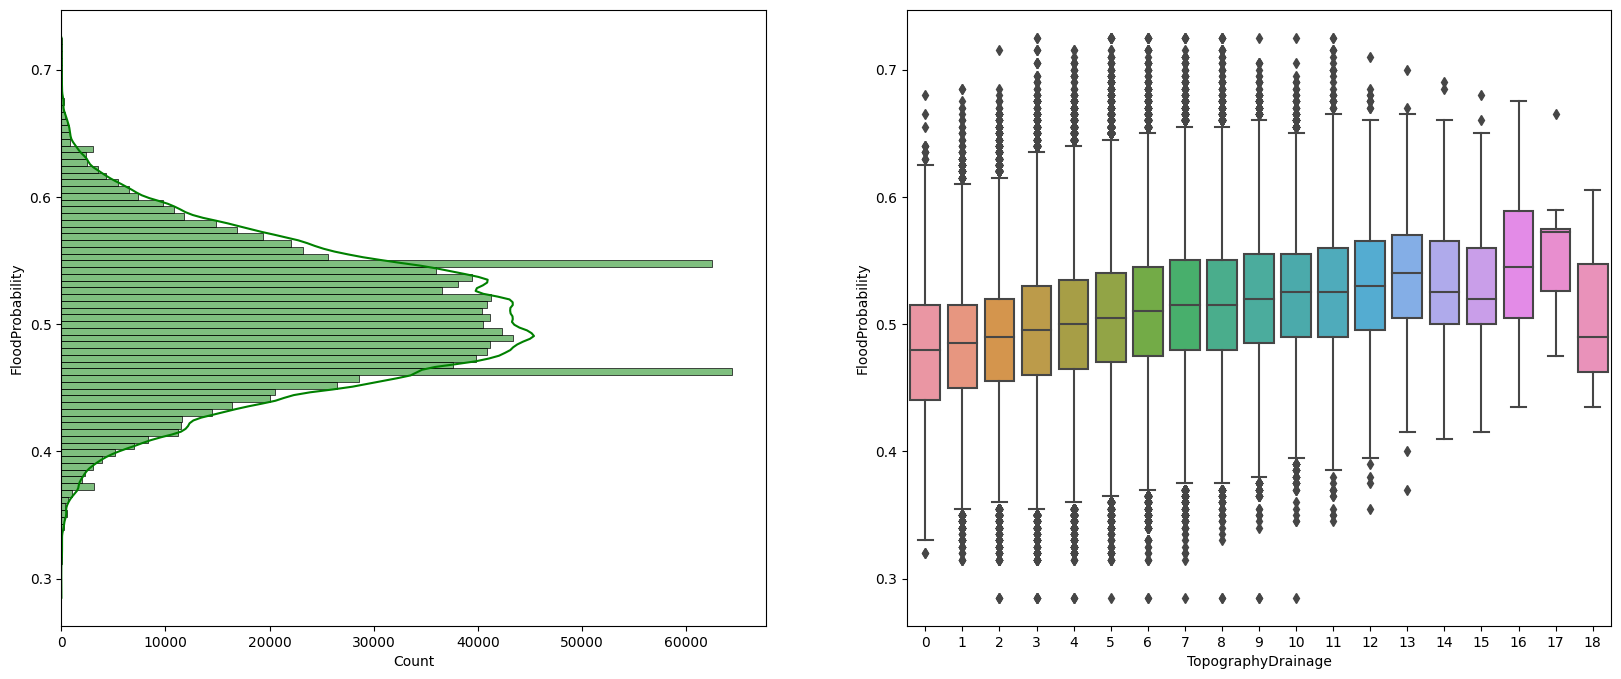

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='TopographyDrainage', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.3 |</span> River Management</b>

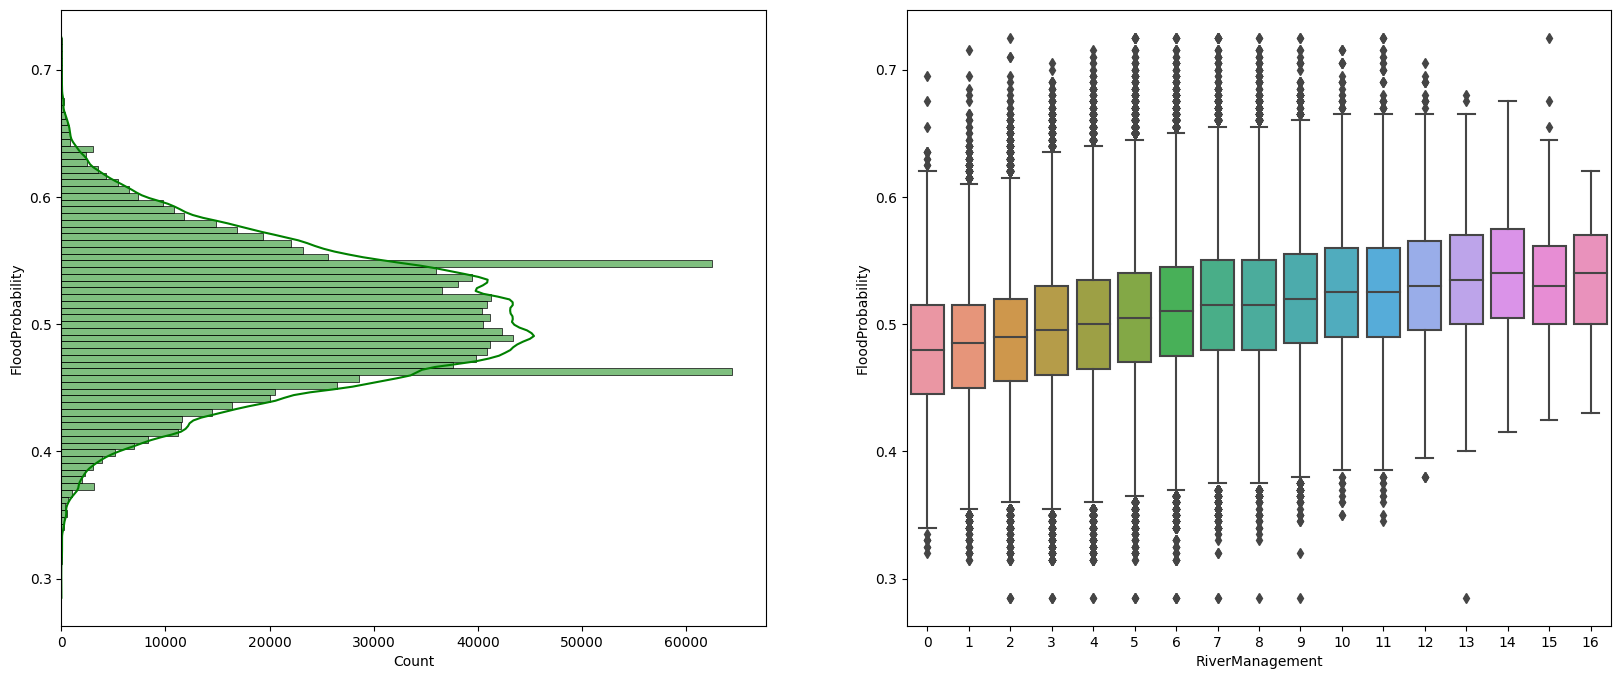

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='RiverManagement', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.4 |</span> Deforestation</b>

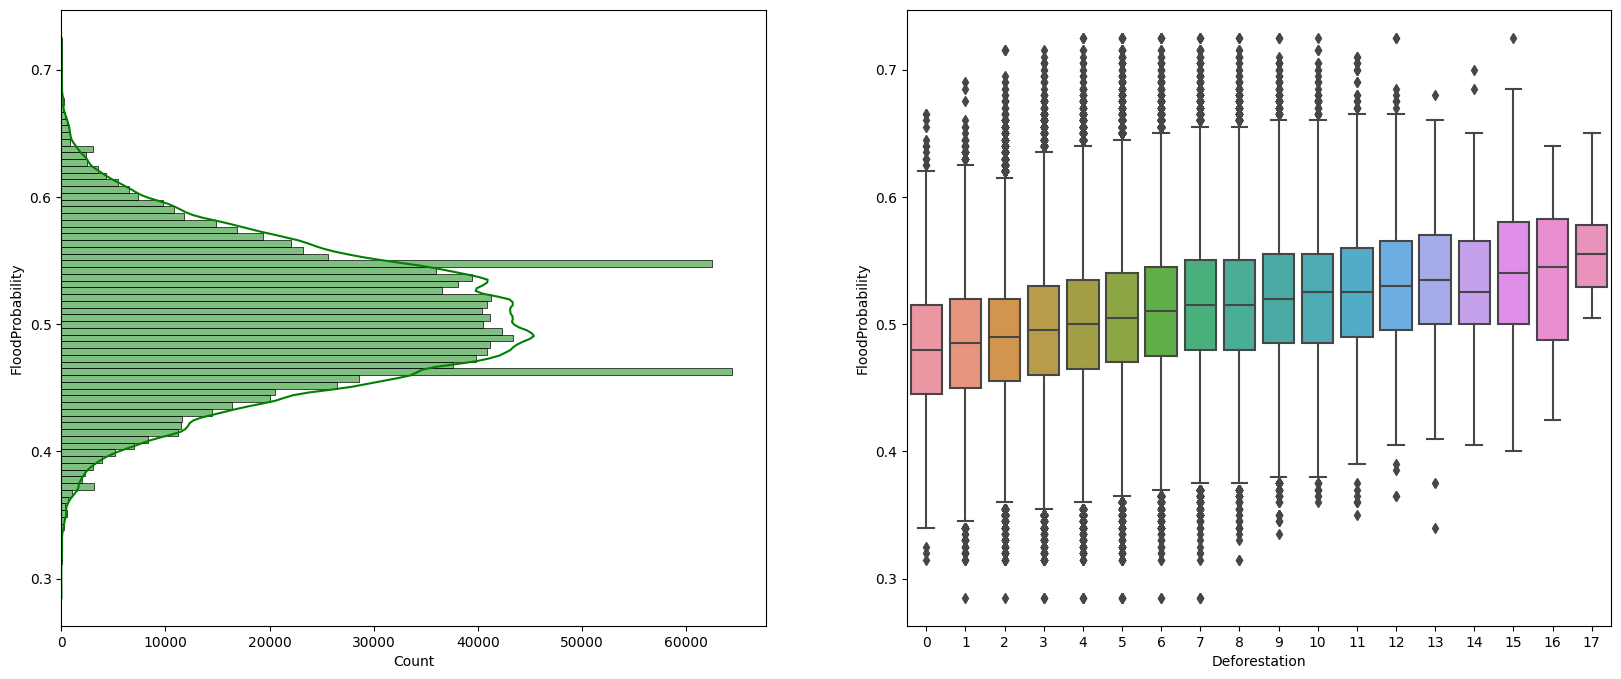

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Deforestation', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.5 |</span> Urbanization</b>

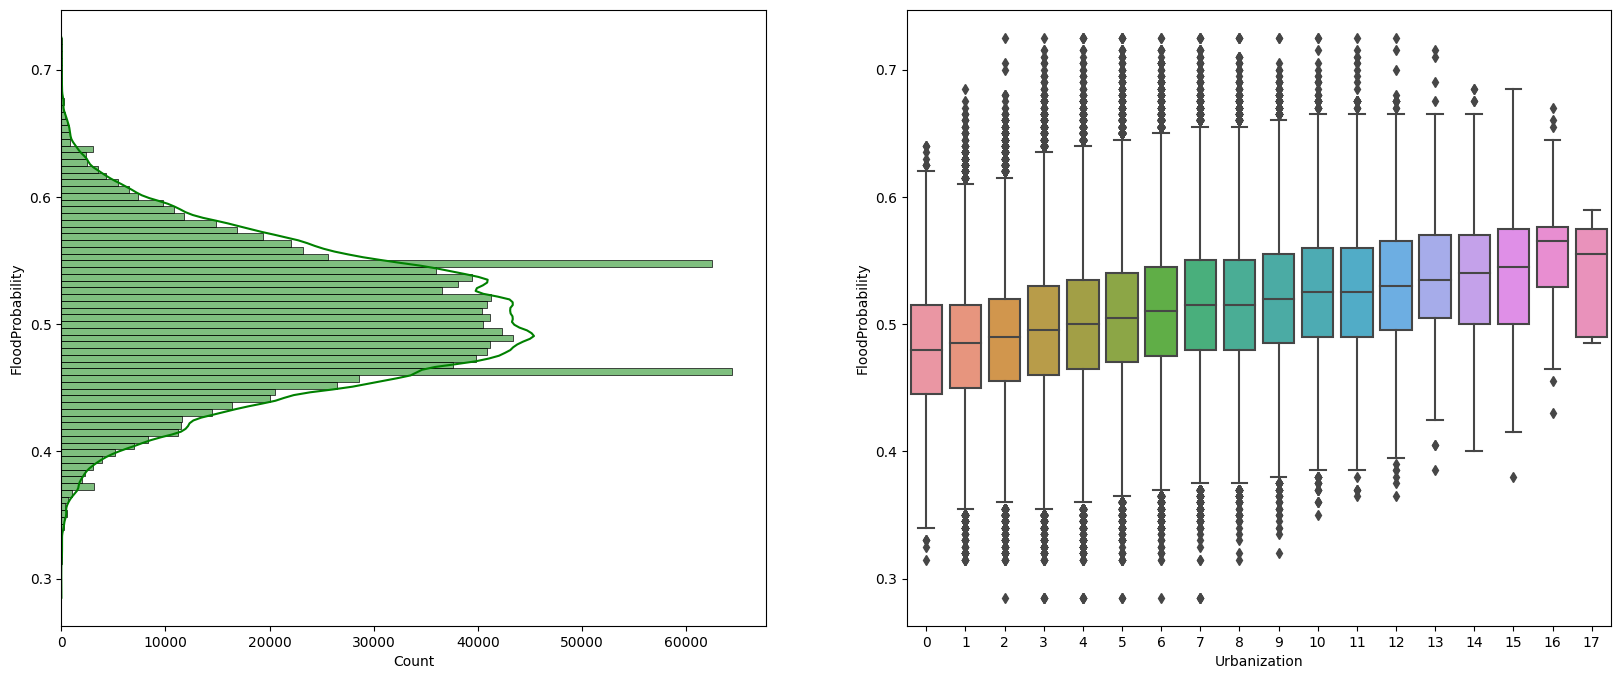

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Urbanization', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.6 |</span> Climate Change</b>

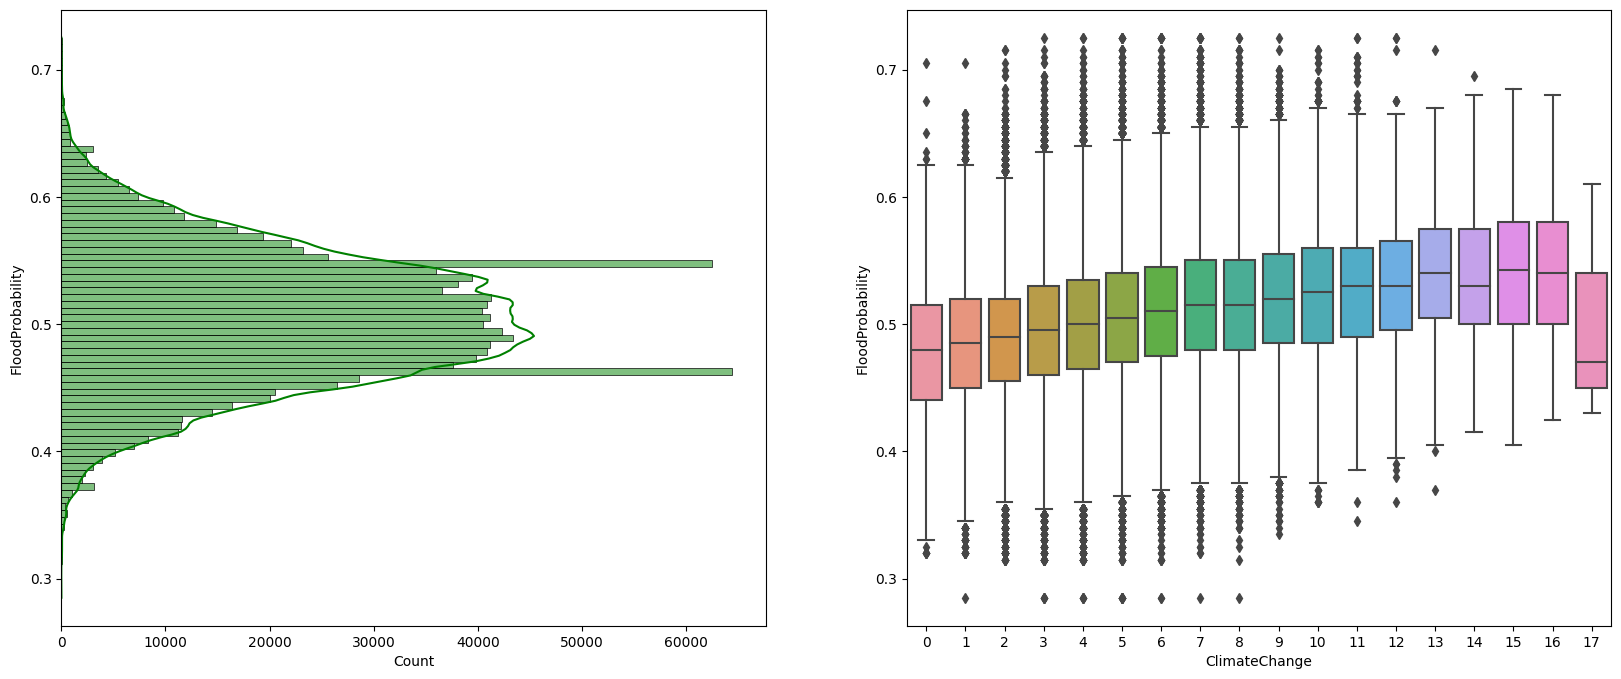

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='ClimateChange', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.7 |</span> DamsQuality</b>

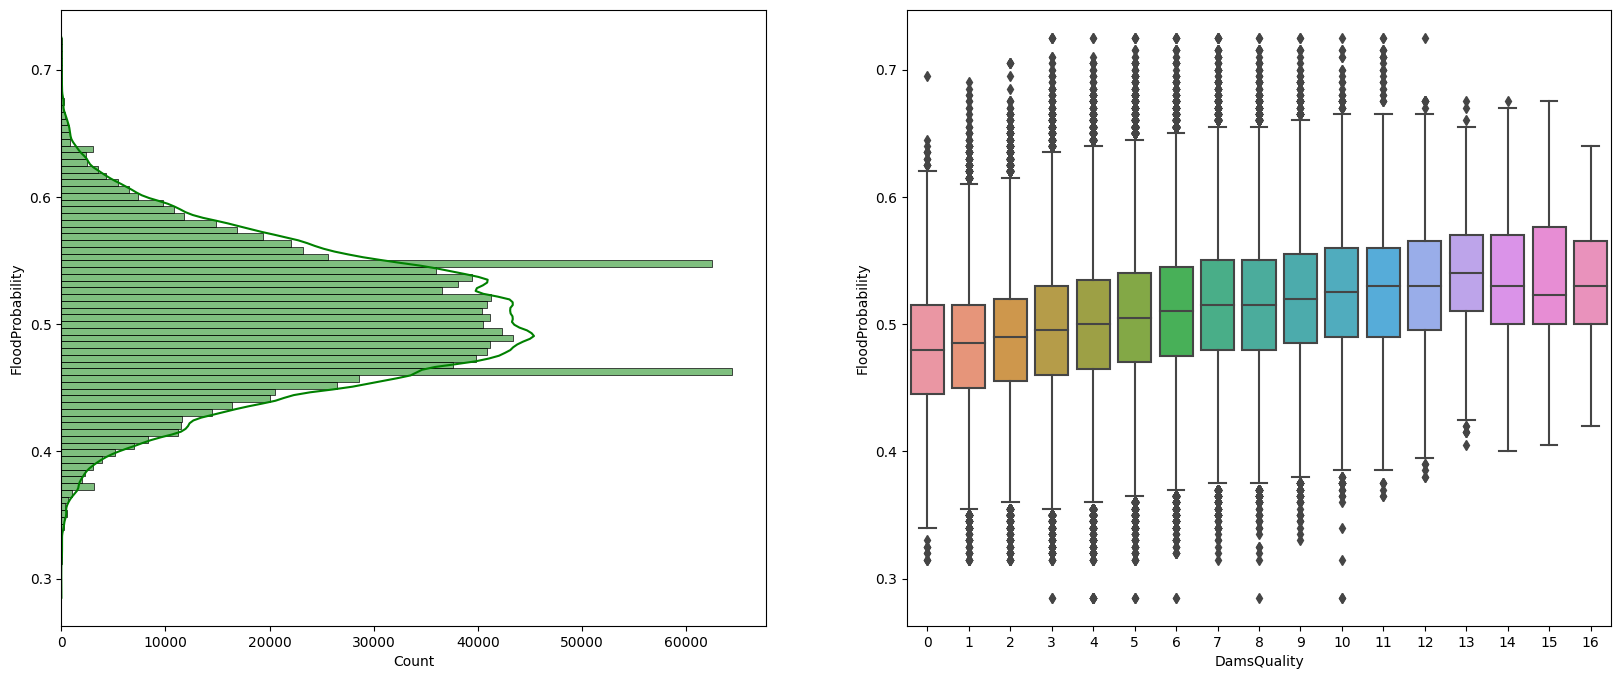

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='DamsQuality', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.8 |</span> Siltation</b>

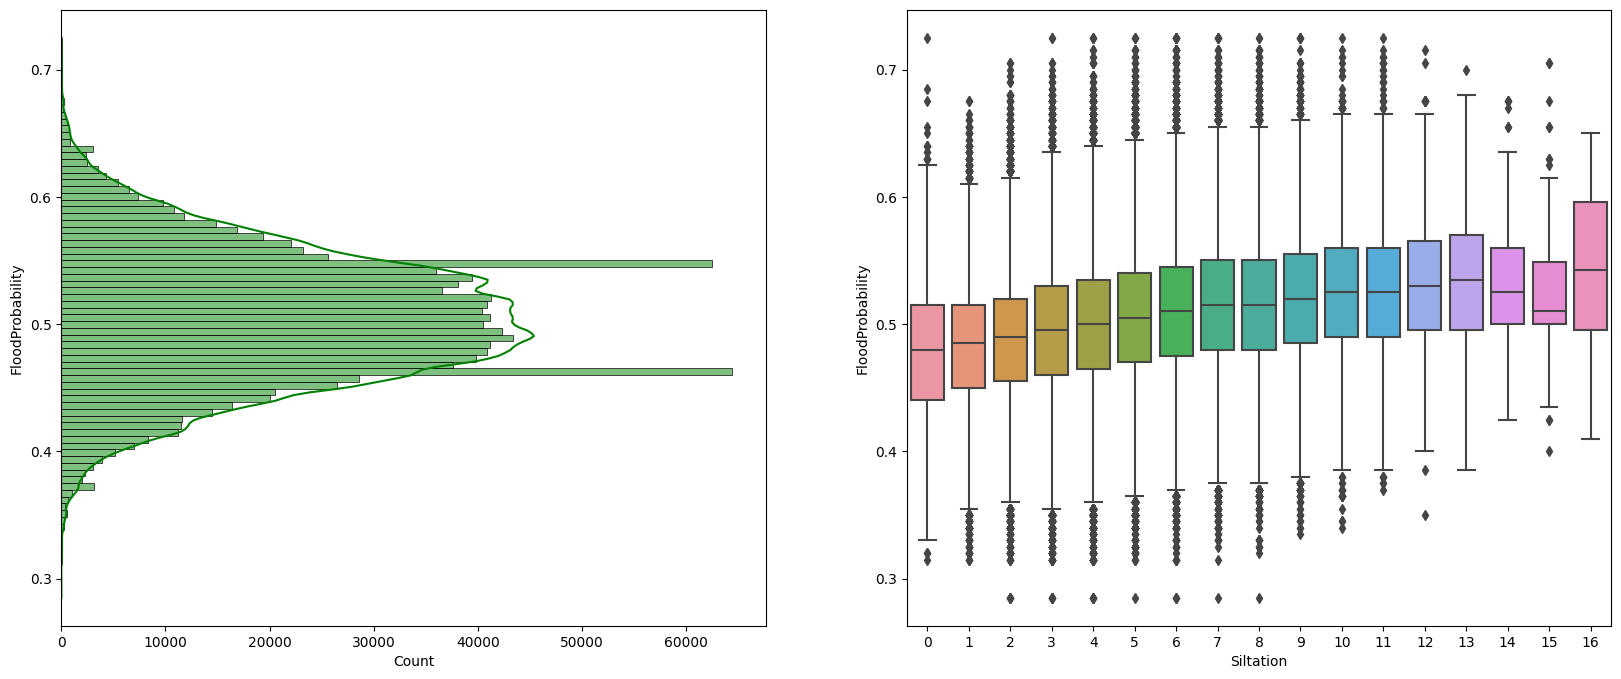

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Siltation', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.9 |</span> Agricultural Practices</b>

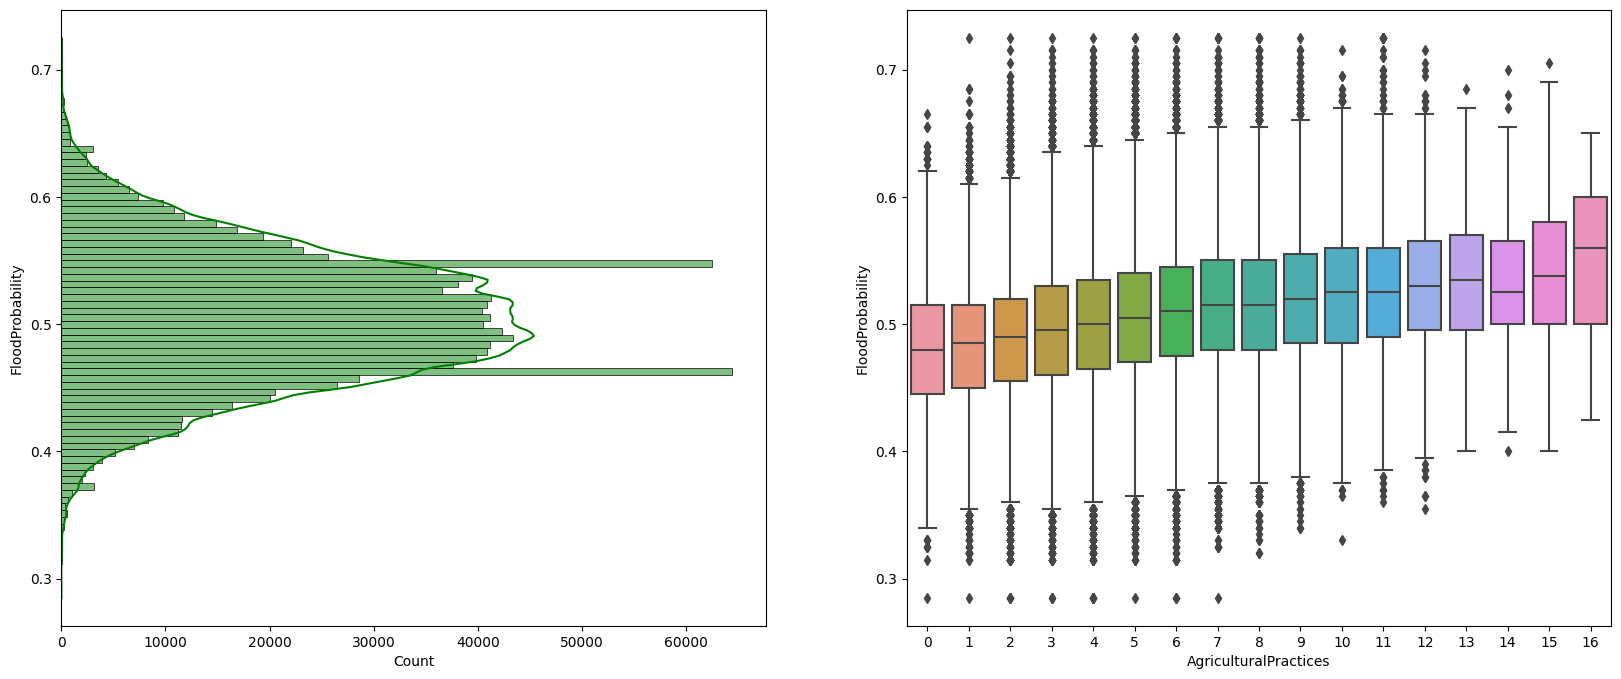

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='AgriculturalPractices', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.10 |</span> Encroachments</b>

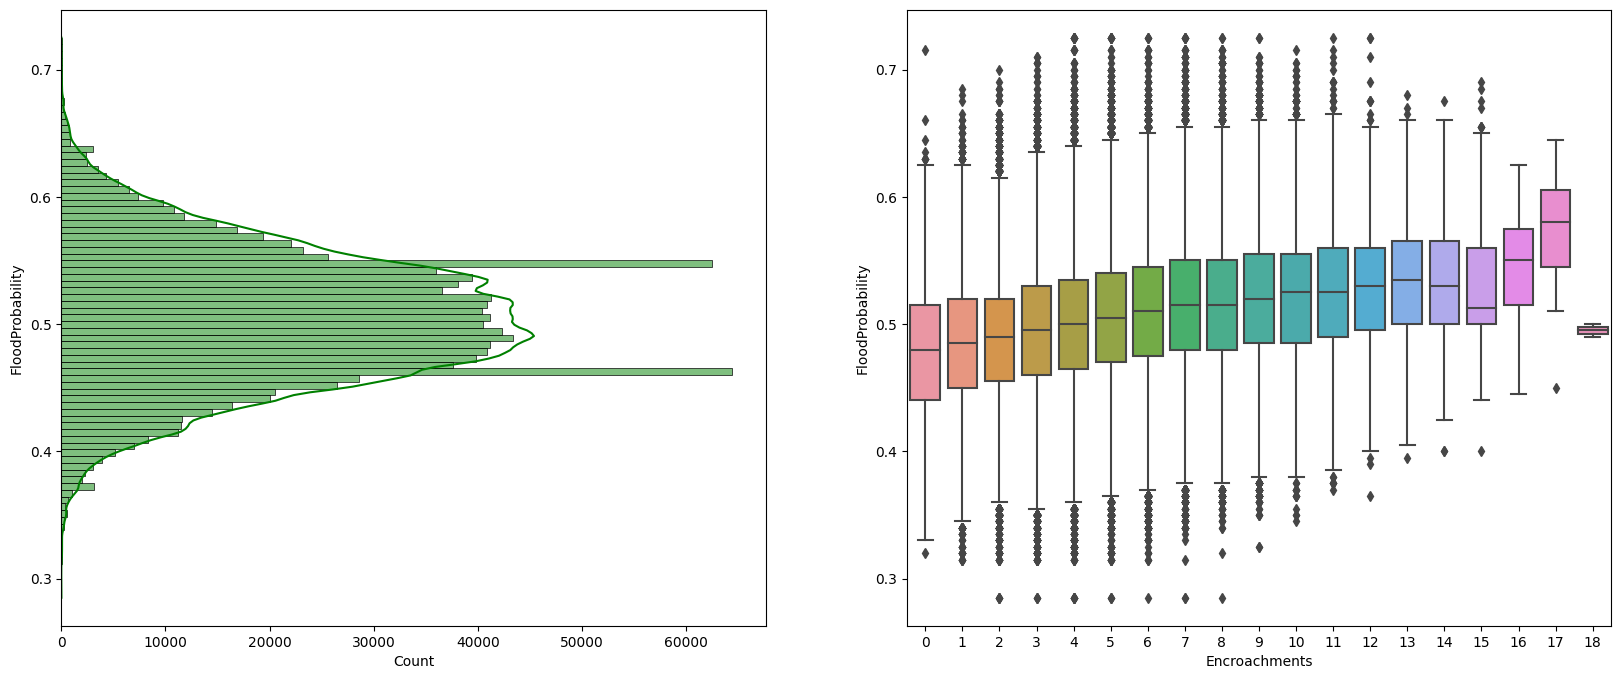

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Encroachments', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.11 |</span> IneffectiveDisasterPreparedness</b>

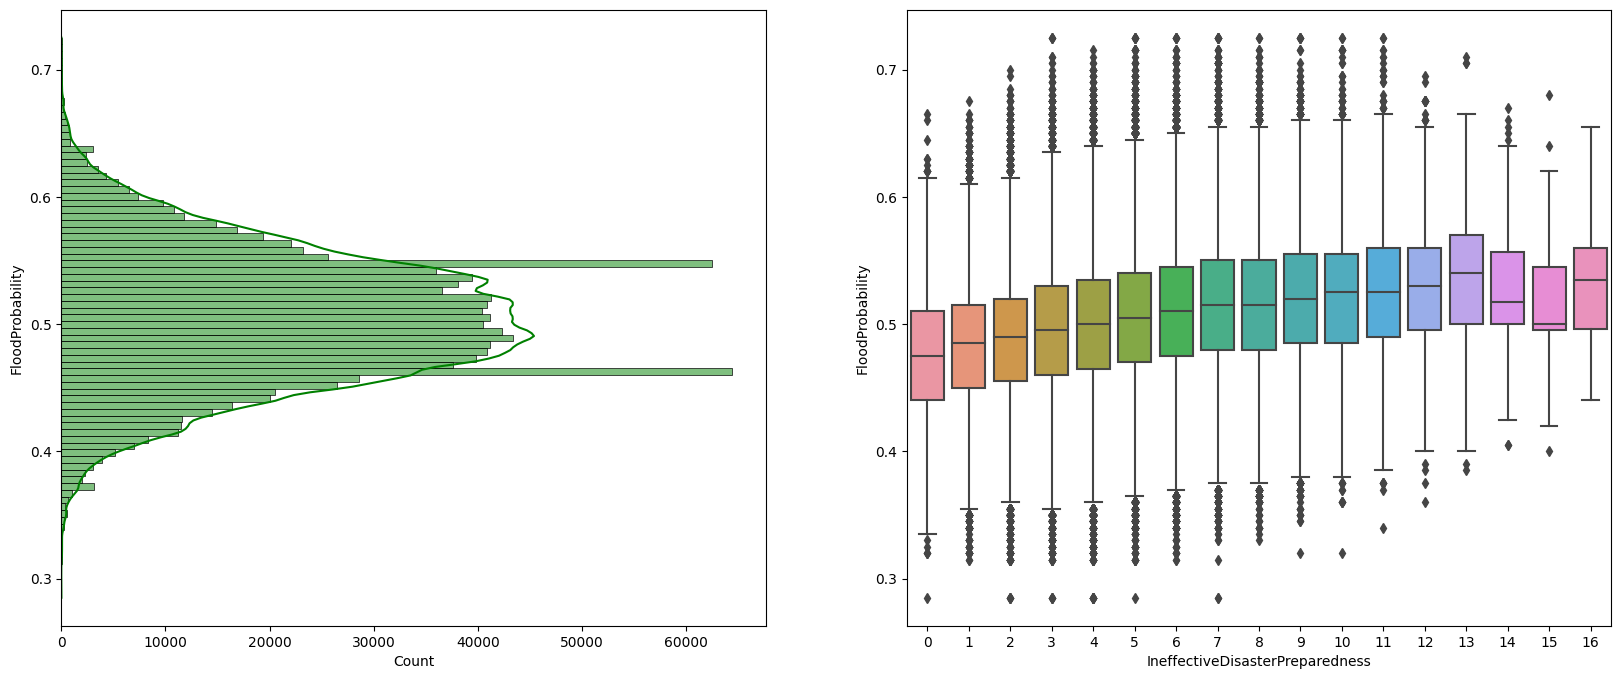

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='IneffectiveDisasterPreparedness', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.12 |</span> DrainageSystems </b>

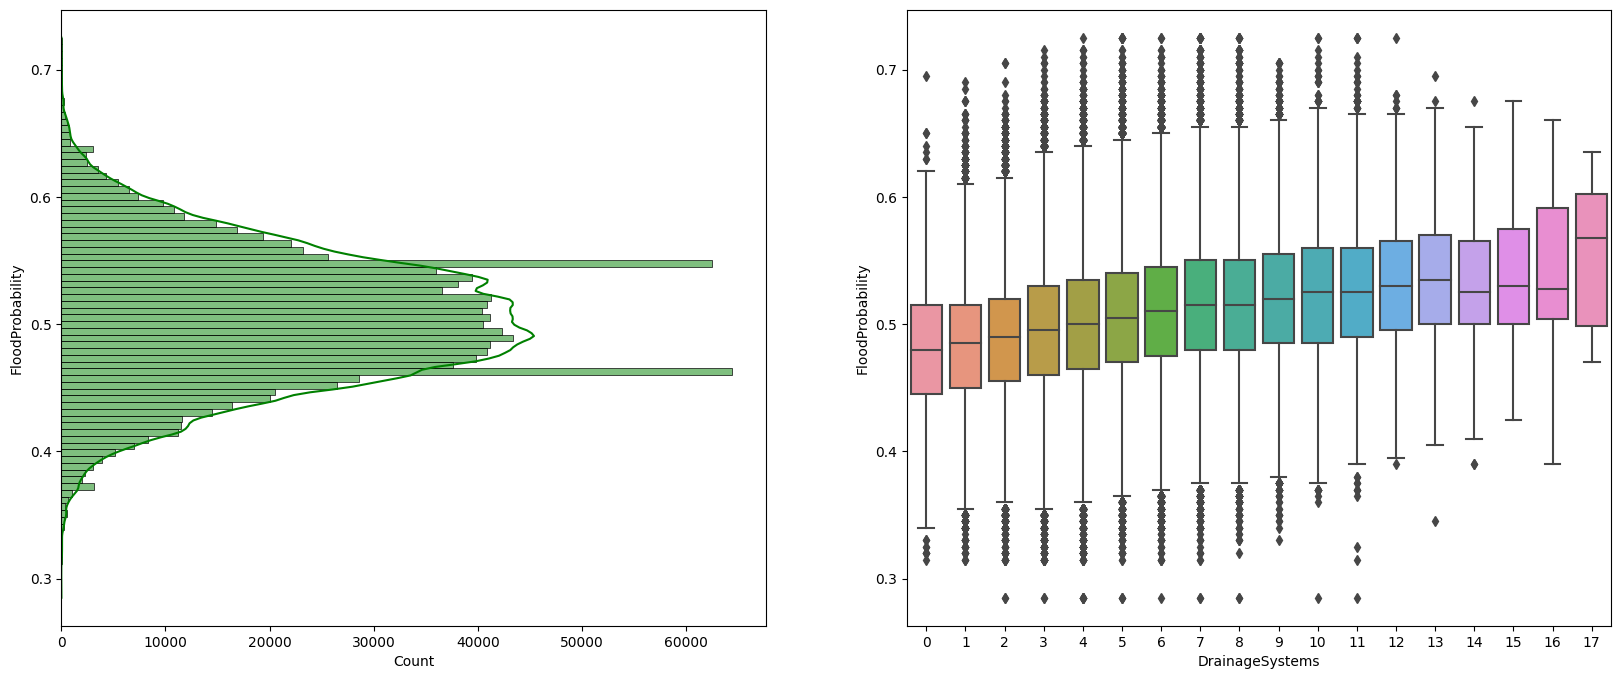

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='DrainageSystems', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.13 |</span> CoastalVulnerability </b>

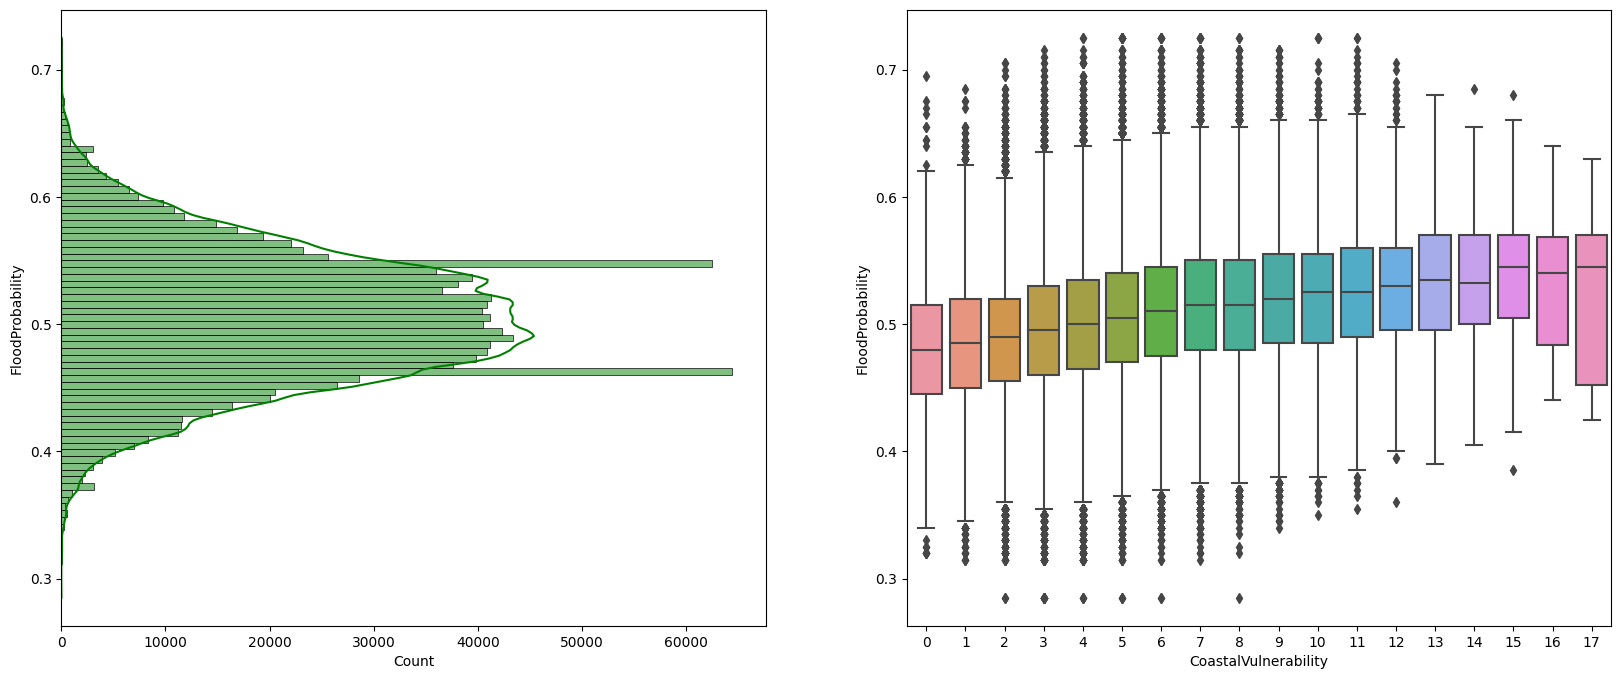

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='CoastalVulnerability', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.14 |</span> Landslides  </b>

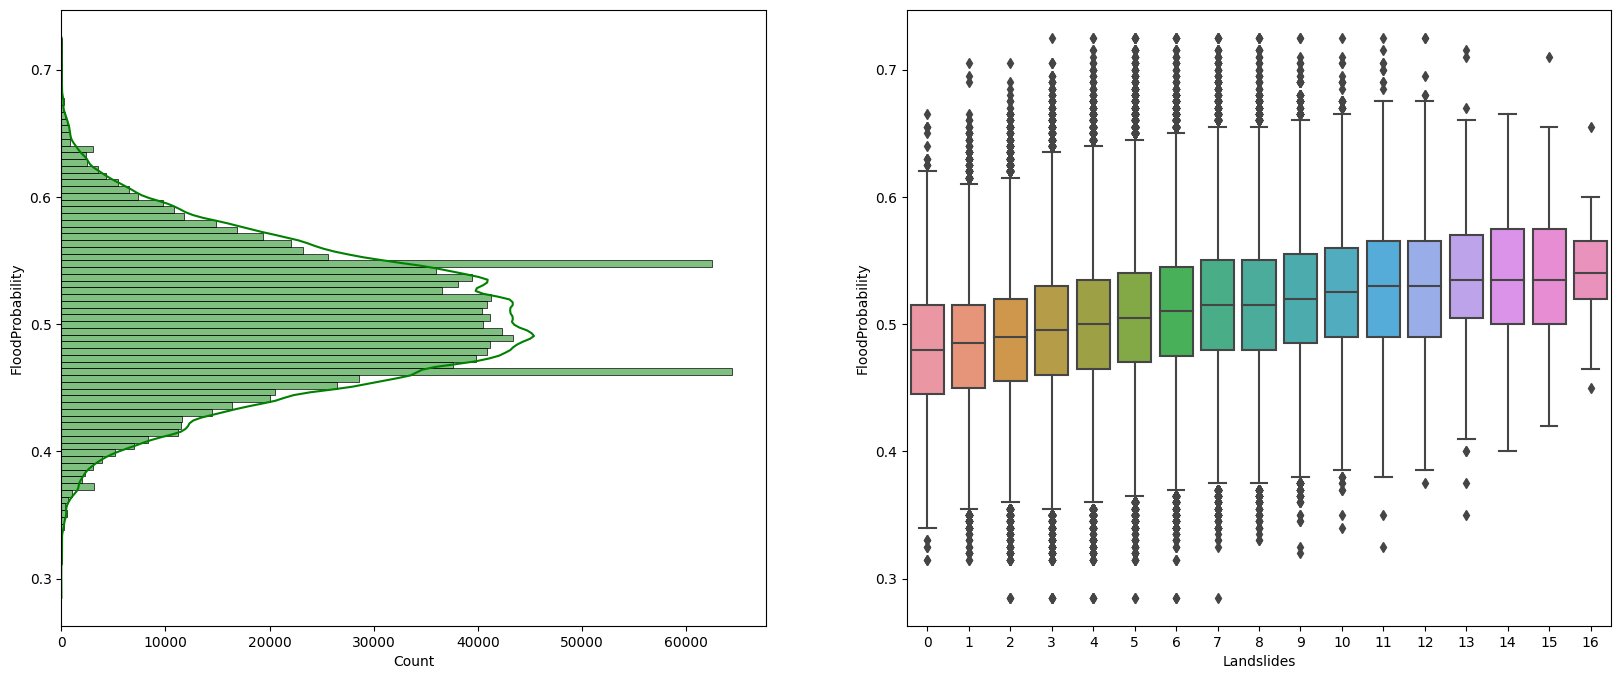

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Landslides', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.15 |</span> Watersheds</b>

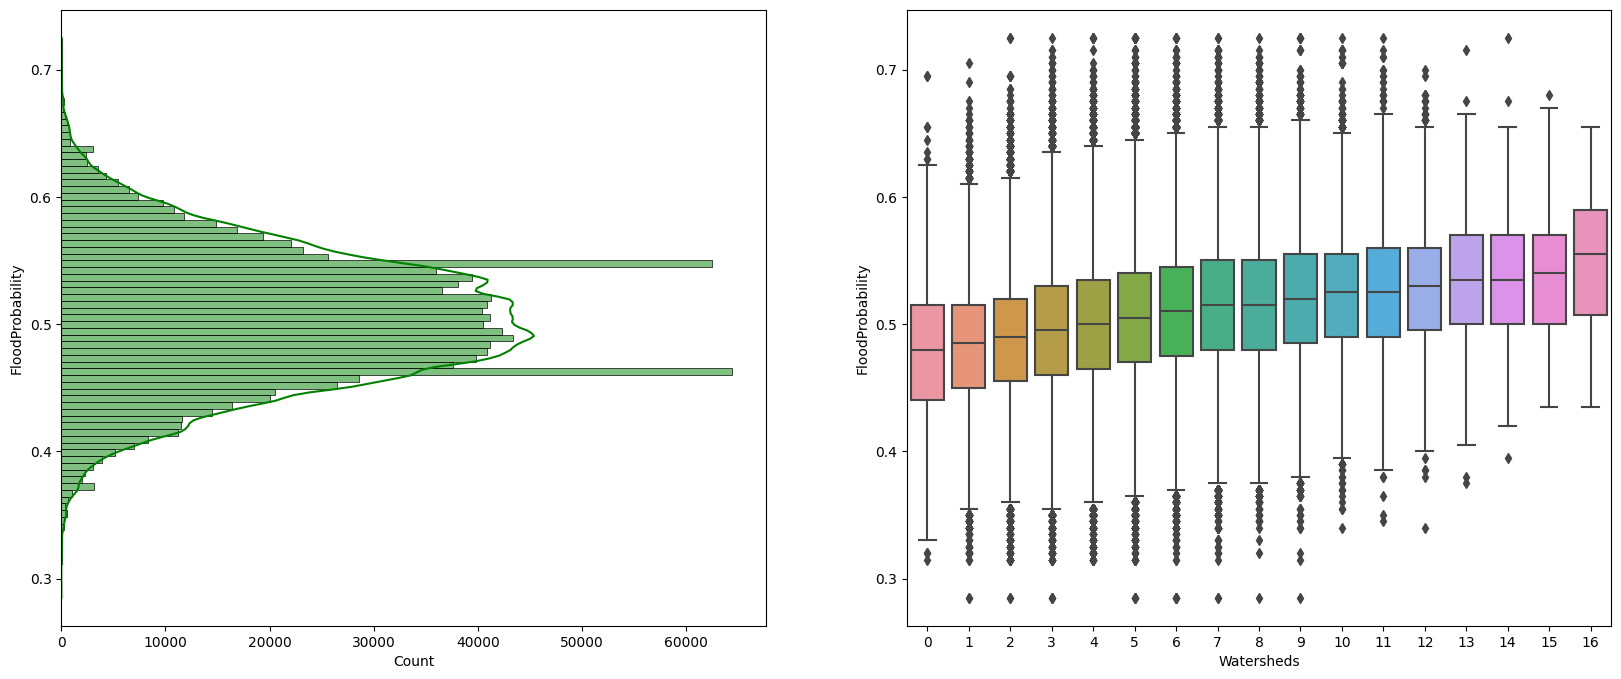

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='Watersheds', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.16 |</span> DeterioratingInfrastructure</b>

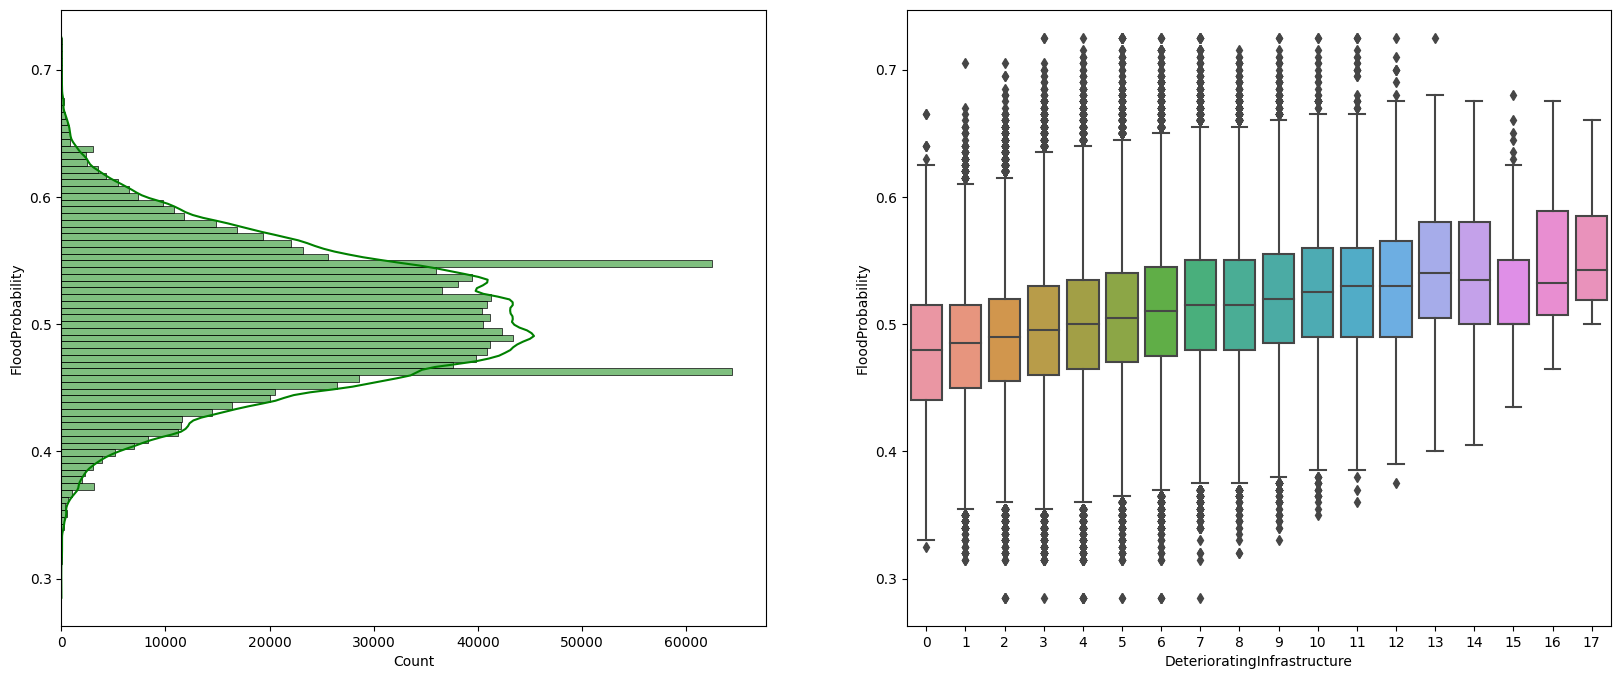

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='DeterioratingInfrastructure', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.17 |</span> PopulationScore </b>

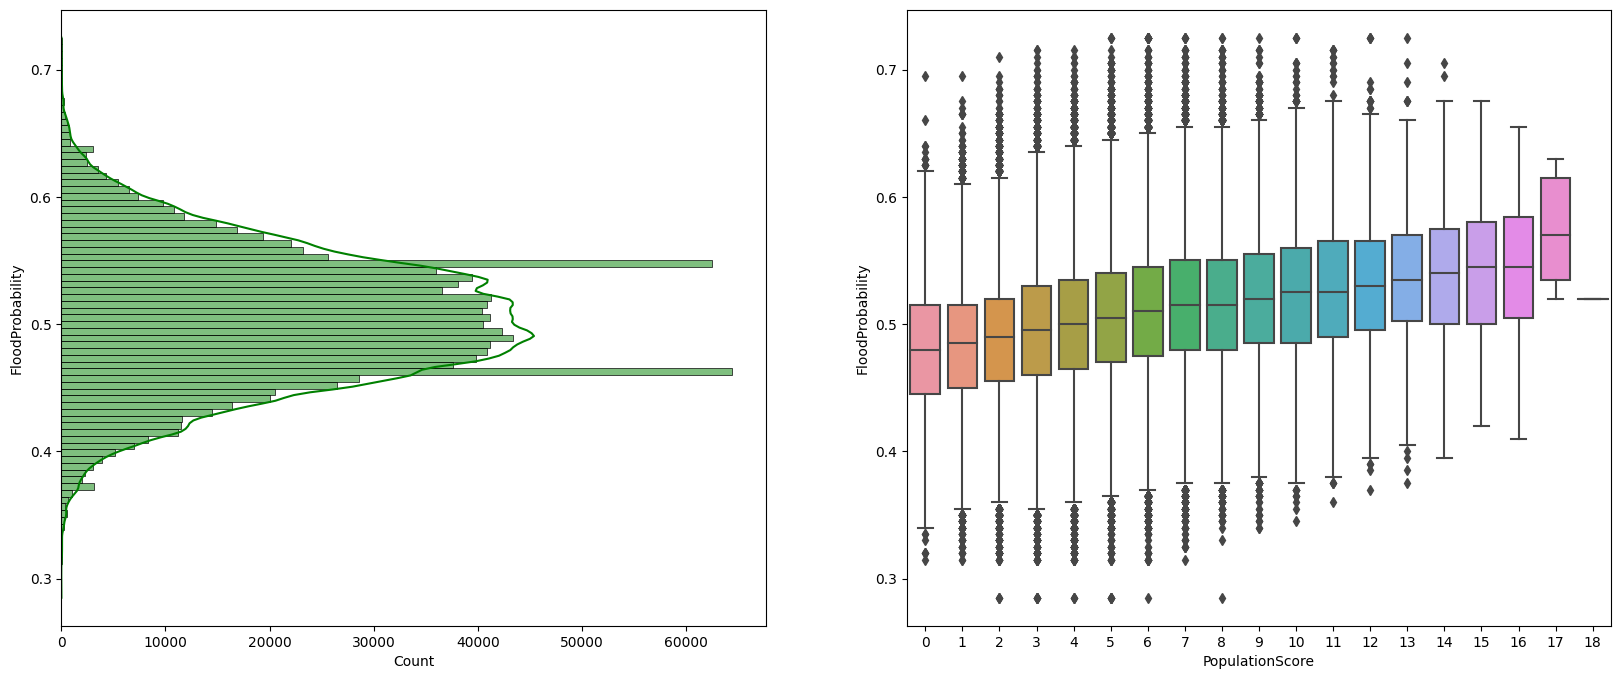

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='PopulationScore', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.18 |</span> WetlandLoss  </b>

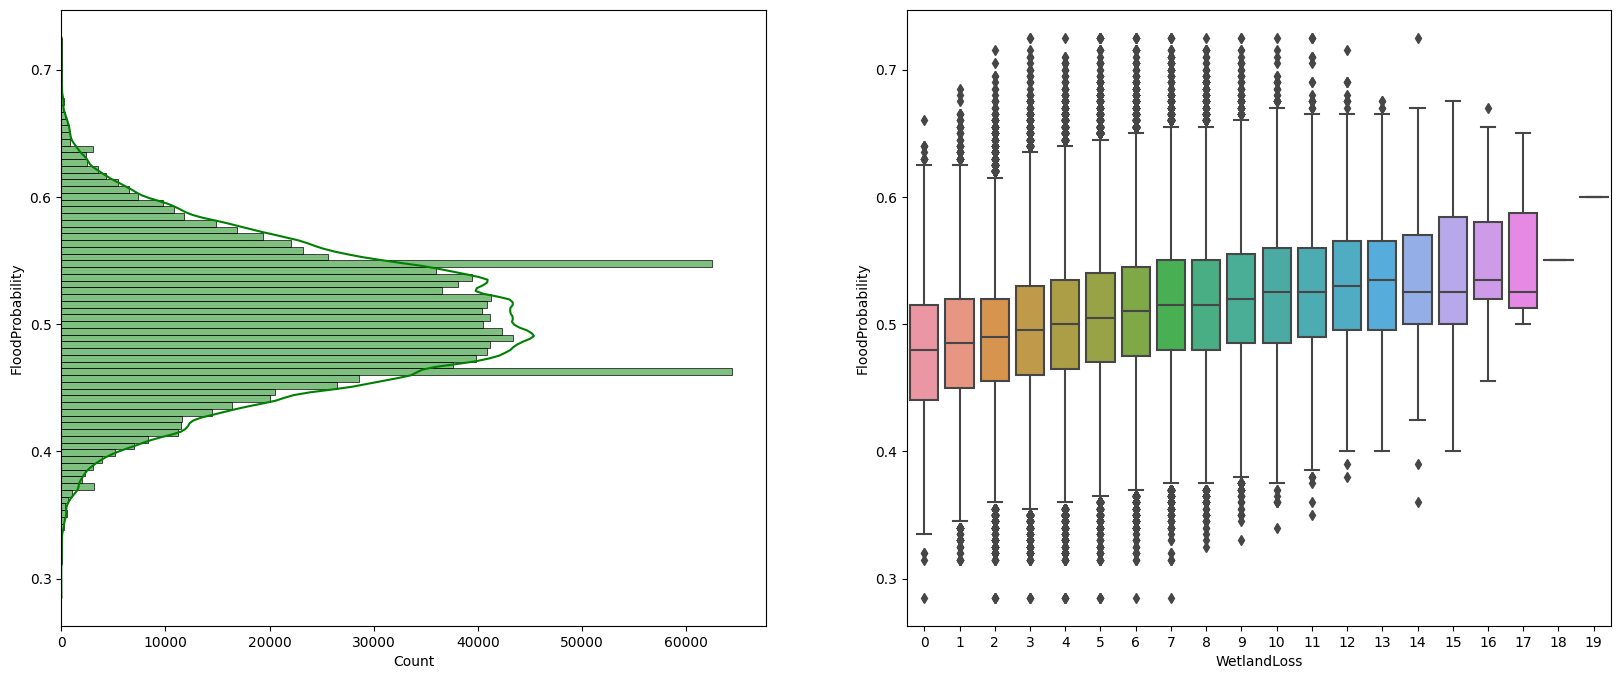

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='WetlandLoss', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.19 |</span> InadequatePlanning  </b>

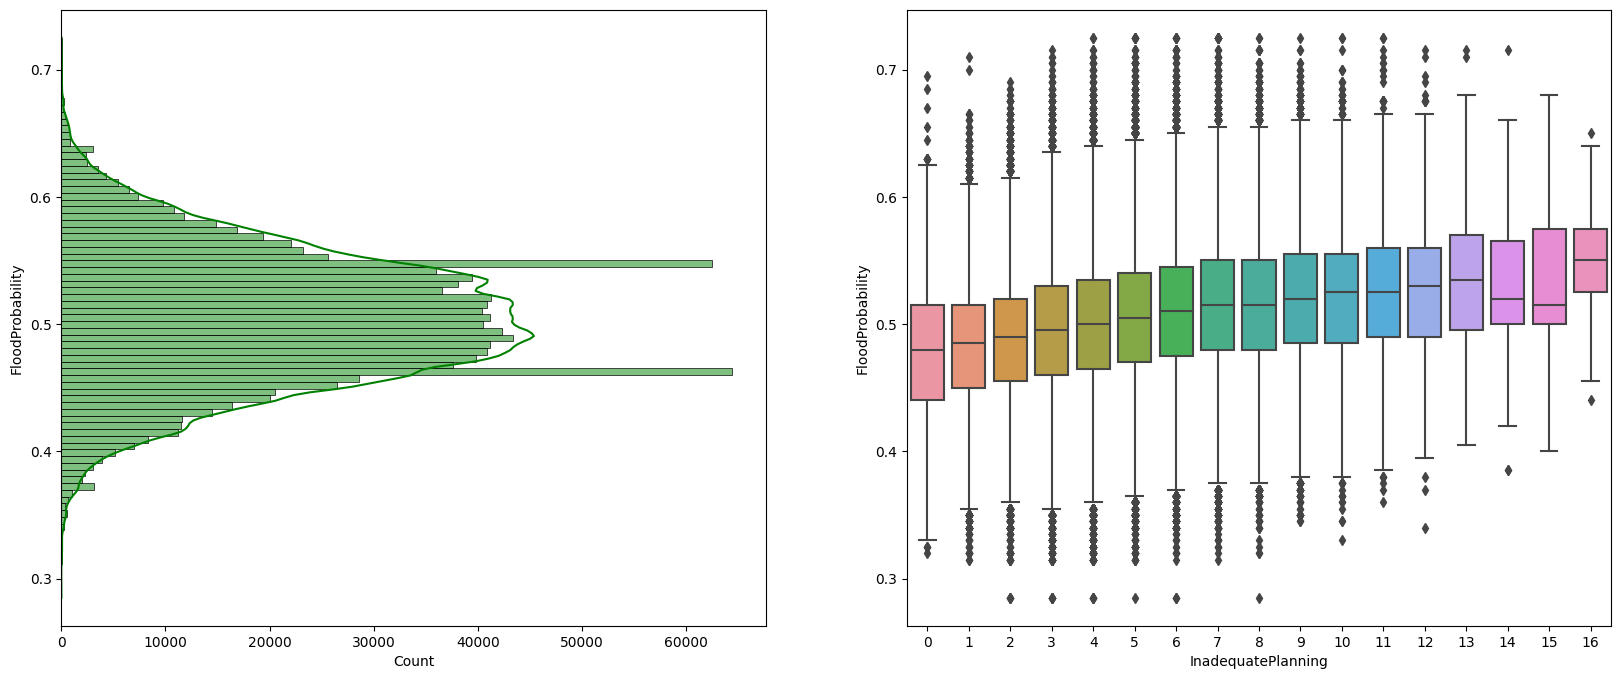

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='InadequatePlanning', y='FloodProbability')
plt.show()

### <b><span style='color:#FFCE30'>5.20 |</span>  PoliticalFactors  </b>

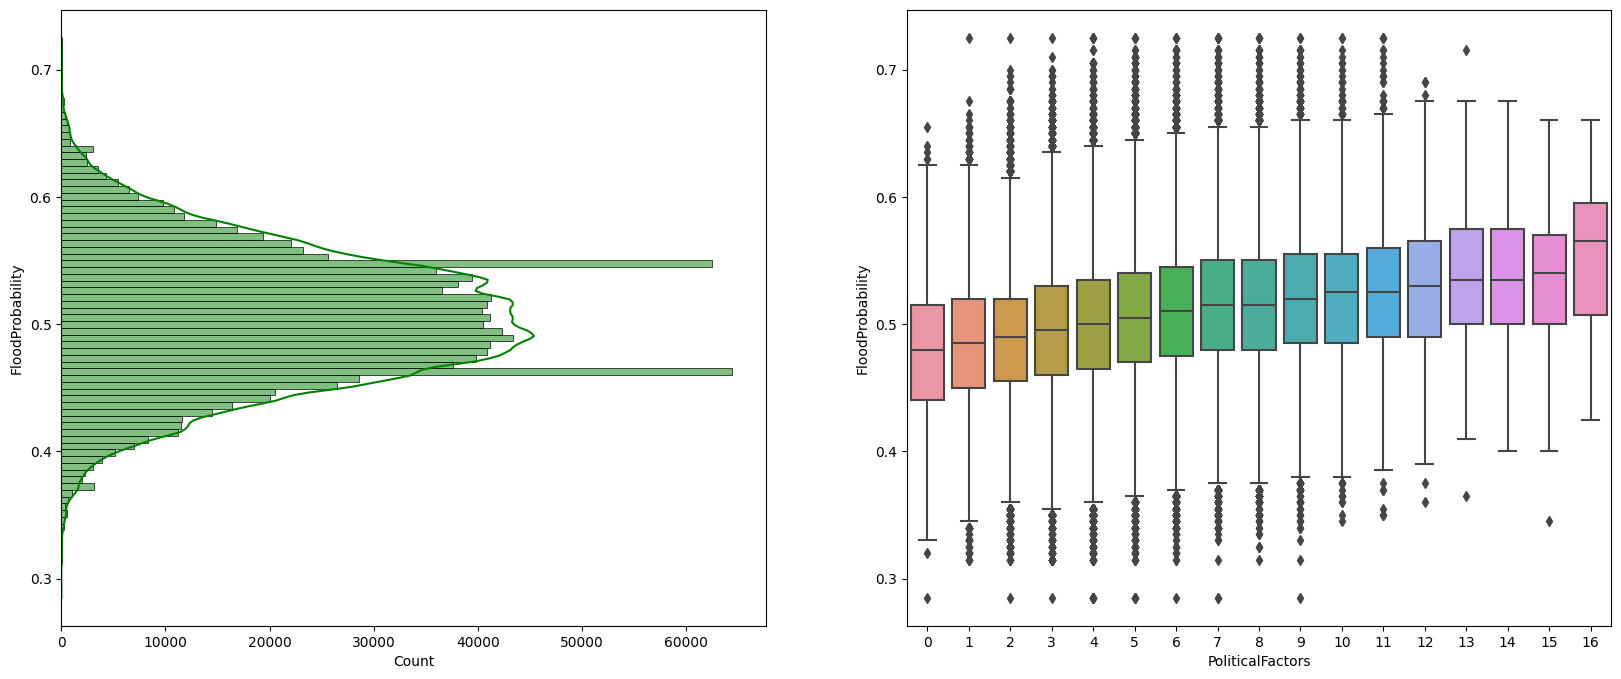

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
sns.histplot(data=train,y='FloodProbability',bins=83,kde=True,color='g')
plt.subplot(122)
sns.boxplot(data=train, x='PoliticalFactors', y='FloodProbability')
plt.show()

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>CORRELATION ANALYSIS</b></div>

In [30]:
train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

In [31]:
selected_features = ['MonsoonIntensity', 
                     'TopographyDrainage', 
                     'RiverManagement',
                     'Deforestation', 
                     'Urbanization', 
                     'ClimateChange', 
                     'DamsQuality',
                     'Siltation', 
                     'AgriculturalPractices', 
                     'Encroachments',
                     'IneffectiveDisasterPreparedness', 
                     'DrainageSystems',
                     'CoastalVulnerability', 
                     'Landslides', 
                     'Watersheds',
                     'DeterioratingInfrastructure',
                     'PopulationScore', 
                     'WetlandLoss',
                     'InadequatePlanning',
                     'PoliticalFactors', 
                     'FloodProbability']

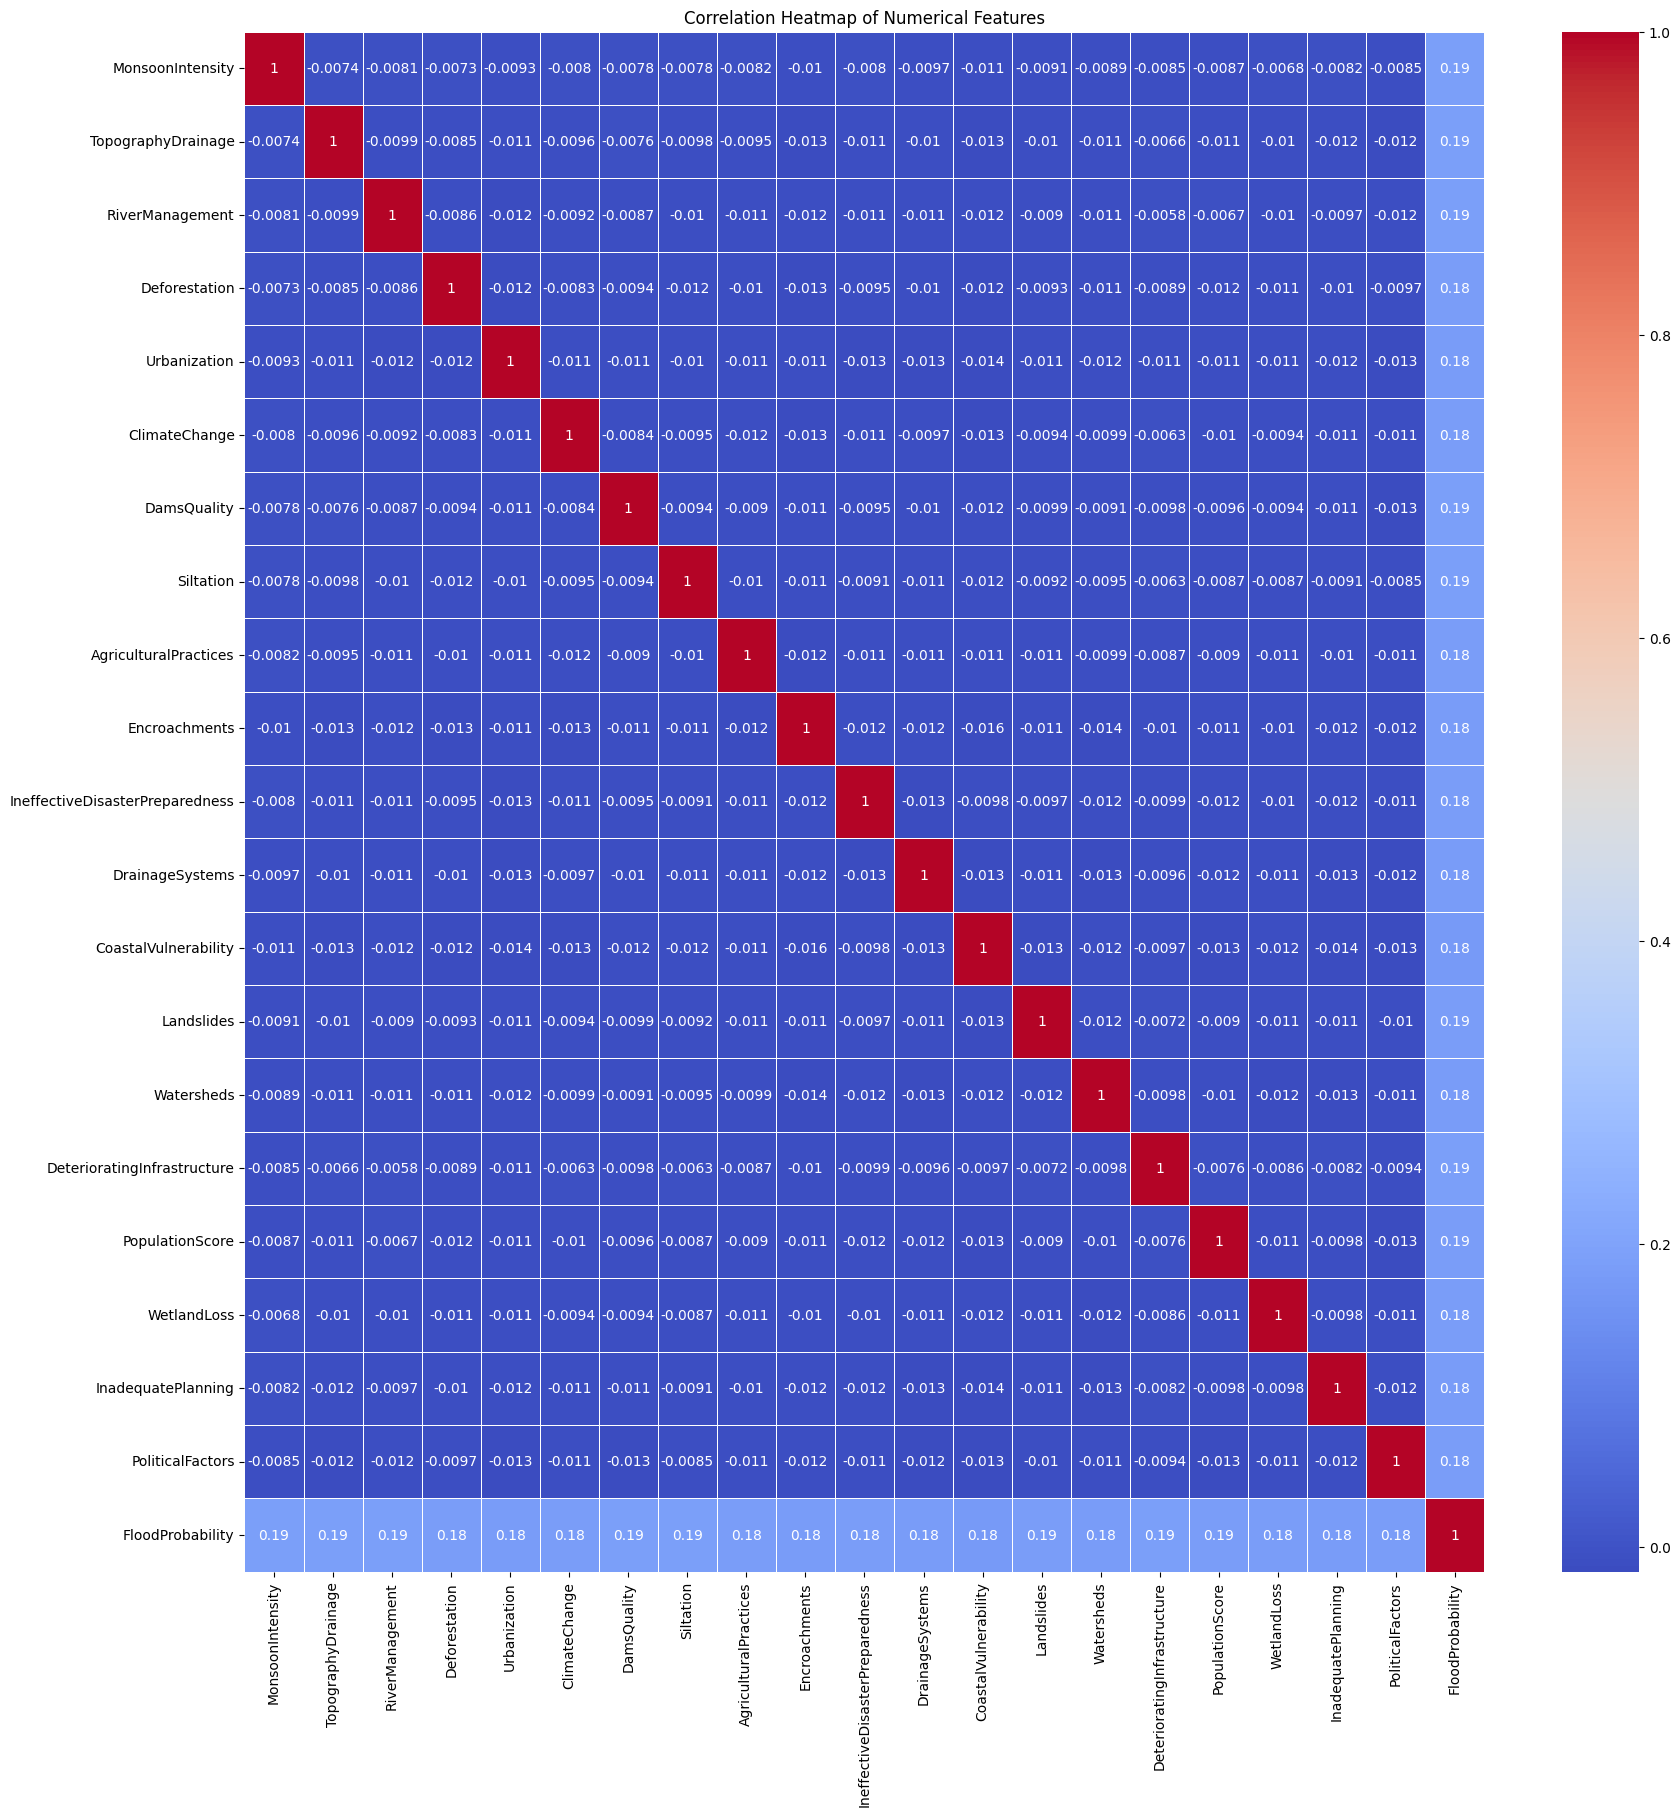

In [32]:
# Calculate the correlation matrix for numerical features only
correlation_matrix = train[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm',linewidths=0.5, annot=correlation_matrix.values)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [33]:
TARGET = 'FloodProbability'
NUMERIC_COLS = [f for f in train._get_numeric_data() if f not in TARGET]
CAT_COLS = list(test.drop(NUMERIC_COLS,axis=1))
print(f'Numeric cols: {len(NUMERIC_COLS)}')
print(f'Cat cols: {len(CAT_COLS)}')

Numeric cols: 20
Cat cols: 0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>FEATURE IMPORTANCE</b></div>

In [34]:
# # Define features and target variable
# X = train.drop(columns=['FloodProbability', 'id'])
# y = train['FloodProbability']

# # Initialize CatBoostRegressor
# catboost_reg = CatBoostRegressor(verbose=0)

# # Fit the model
# catboost_reg.fit(X, y)

# # Get feature importances
# feature_importance = catboost_reg.get_feature_importance(type='PredictionValuesChange')

# # Get the feature names from 'X'
# feature_names = X.columns

# # Sort the feature importances and get the indices of the sorted array
# sorted_idx = np.argsort(feature_importance)

# # Define the number of top features to plot
# TOP = 20

# # Plot only the top 'TOP' features
# fig = plt.figure(figsize=(10, 8))
# plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
# plt.yticks(np.arange(len(sorted_idx))[-TOP:], feature_names[sorted_idx][-TOP:])
# plt.xlabel('Feature Importance')
# plt.title(f'Feature Importance - Top {TOP}')
# plt.show()


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>8 |</span></b> <b>MODELLING PIPELINE</b></div>

### Drop Columns

In [35]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):

        return X.drop(self.cols, axis=1)


### Feature Engineering

In [36]:
# Define your FE transformer class
class FE(BaseEstimator, TransformerMixin):
    def __init__(self, use_quantile=False, sort=False):
        self.use_quantile = use_quantile
        self.sort = sort
        self.numeric_cols = None  # Initialize attribute to store numeric column names

    def fit(self, X, y=None):
        # Store the numeric column names during fitting
        self.numeric_cols = X.columns.tolist()
        return self

    def transform(self, X):
        x_copy = X.copy()
        features = x_copy.columns.tolist()
        x_copy['mean_features'] = 0.1 * x_copy[features].mean(axis=1)
        x_copy['std_features'] = x_copy[features].std(axis=1)
        x_copy['max_features'] = x_copy[features].max(axis=1)
        x_copy['min_features'] = x_copy[features].min(axis=1)
        x_copy['median_features'] = 0.1 * x_copy[features].median(axis=1)
        x_copy['sum_features'] = X[self.numeric_cols].sum(axis=1)
        if self.sort:
            sorted_features = [f'sort_{col}' for col in self.numeric_cols]
            sorted_values = np.sort(x_copy[self.numeric_cols].values, axis=1)
            x_copy[sorted_features] = sorted_values
        if self.use_quantile:
            x_copy['q1'] = x_copy[features].quantile(0.25, axis=1)
            x_copy['q3'] = x_copy[features].quantile(0.75, axis=1)

        x_copy = x_copy.drop(features, axis=1)

        return x_copy


### Pipeline

In [37]:
# Define your preprocessing pipeline with the FE step
named_preprocessing_pipeline = Pipeline([
    ('fe', FE(use_quantile=True, sort=True)),  # Add FE step here
    ('drop', DropColumn()),
    ('prep', ColumnTransformer([], remainder='passthrough').set_output(transform='pandas')),
    ('scale', RobustScaler().set_output(transform='pandas'))
])

named_preprocessing_pipeline

Pipeline(steps=[('fe', FE(sort=True, use_quantile=True)),
                ('drop', DropColumn()),
                ('prep',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('scale', RobustScaler())])

In [38]:
#checking output on df dataframe
df_train = named_preprocessing_pipeline.fit_transform(train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 29 columns):
 #   Column                                           Non-Null Count    Dtype  
---  ------                                           --------------    -----  
 0   remainder__mean_features                         1117957 non-null  float64
 1   remainder__std_features                          1117957 non-null  float64
 2   remainder__max_features                          1117957 non-null  float64
 3   remainder__min_features                          1117957 non-null  float64
 4   remainder__median_features                       1117957 non-null  float64
 5   remainder__sum_features                          1117957 non-null  float64
 6   remainder__sort_MonsoonIntensity                 1117957 non-null  float64
 7   remainder__sort_TopographyDrainage               1117957 non-null  float64
 8   remainder__sort_RiverManagement                  1117957 non-null  float64
 9   remaind

In [39]:
df_train.head()

,remainder__mean_features,remainder__std_features,remainder__max_features,remainder__min_features,remainder__median_features,remainder__sum_features,remainder__sort_MonsoonIntensity,remainder__sort_TopographyDrainage,remainder__sort_RiverManagement,remainder__sort_Deforestation,remainder__sort_Urbanization,remainder__sort_ClimateChange,remainder__sort_DamsQuality,remainder__sort_Siltation,remainder__sort_AgriculturalPractices,remainder__sort_Encroachments,remainder__sort_IneffectiveDisasterPreparedness,remainder__sort_DrainageSystems,remainder__sort_CoastalVulnerability,remainder__sort_Landslides,remainder__sort_Watersheds,remainder__sort_DeterioratingInfrastructure,remainder__sort_PopulationScore,remainder__sort_WetlandLoss,remainder__sort_InadequatePlanning,remainder__sort_PoliticalFactors,remainder__sort_FloodProbability,remainder__q1,remainder__q3
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.399407,-0.561660,-0.5,-0.6875,-1.0,-0.399407,-0.6875,0.00,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-0.5,0.0,-1.0
1,-0.398913,0.514241,0.0,-6.2500,-1.0,-0.398913,-6.2500,-1.55,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.103312,-0.172424,-0.5,0.3750,0.0,0.103312,0.3750,-1.00,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.5,-0.5,0.0,0.0
3,0.598122,-0.664207,-0.5,0.4375,0.0,0.598122,0.4375,0.00,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,1.0,0.0
4,-2.577360,-1.283837,-1.5,-1.0625,-2.0,-2.577360,-1.0625,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-1.0,-1.0,-1.5,-1.0,-1.0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>9 |</span></b> <b>INITIAL MODEL TRAINING</b></div>

In [40]:
X = train.drop(['FloodProbability'], axis=1)
y = train['FloodProbability']

In [41]:
kf = KFold(n_splits=config['N_SPLITS'], random_state=config['SEED'],shuffle=True)

In [42]:
scores, oof, test_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

In [43]:
def score_model(estimator, label='', preprocessing_pipeline=None, X_train=None, y_train=None, test=None, kf=None):
    if preprocessing_pipeline is None:
        print("Preprocessing pipeline not provided.")
        return
    
    if X_train is None or y_train is None or test is None or kf is None:
        print("Data or cross-validation not provided.")
        return
    
    val_predictions = np.zeros((len(X_train)))
    test_predictions = np.zeros((len(test)))
    val_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        model = clone(estimator)
        
        X_train_fold = X_train.iloc[train_idx].reset_index(drop=True)
        y_train_fold = y_train.iloc[train_idx].reset_index(drop=True)
        
        X_val_fold = X_train.iloc[val_idx].reset_index(drop=True)
        y_val_fold = y_train.iloc[val_idx].reset_index(drop=True)
        
        X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_fold, y_train_fold)
        X_val_preprocessed = preprocessing_pipeline.transform(X_val_fold)
        
        model.fit(X_train_preprocessed, y_train_fold)
        val_preds = model.predict(X_val_preprocessed)
        val_predictions[val_idx] += val_preds
        
        test_predictions += model.predict(preprocessing_pipeline.transform(test)) / kf.get_n_splits()
        
        val_score = r2_score(y_val_fold, val_preds)
        val_scores.append(val_score)
        
        print(f'Fold {fold+1}: {val_score:.5f}')
    
    print(colored(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}', 'green'))
    
    return val_scores, val_predictions, test_predictions



In [44]:
%%time
# # Define your XGBoost model
# xgb_params ={'n_estimators': 1867, 'max_depth': 10, 'learning_rate': 0.24942249270006886, 'subsample': 0.8180899007903981, 'gamma': 0.0018079351974587049, 'alpha': 3.518873834962252, 'min_child_weight': 8}


# xgb_model = xgb.XGBRegressor(**xgb_params,
#                              random_state=config['SEED'],
#                              tree_method='gpu_hist')


# xgb_model = xgb.XGBRegressor(n_estimators=2000,
#                              max_depth=5,
#                              learning_rate=0.038,
#                              random_state=config['SEED'],
#                              tree_method='gpu_hist')


xgb_model = xgb.XGBRegressor(n_estimators=1200,
                             max_depth=6,
                             learning_rate= 0.039987569,
                             random_state=config['SEED'],
                             tree_method='gpu_hist')


# Use the score_model function
scores['XGB'],oof['XGB'],test_preds['XGB'] = score_model(xgb_model, 'XGBoost', named_preprocessing_pipeline, X, y, test, kf)

Fold 1: 0.86891
Fold 2: 0.86958
Fold 3: 0.86875
Fold 4: 0.86901
Fold 5: 0.86923
Val Score: 0.86910 ± 0.00029 | XGBoost
CPU times: user 1min 54s, sys: 10.4 s, total: 2min 4s
Wall time: 1min 42s


In [45]:
%%time
# Define your CatBoostRegressor model
catboost_model = CatBoostRegressor(iterations=2000, 
                                   verbose=False, 
                                   random_state=config['SEED'],
                                   task_type='GPU')


# catboost_params ={'depth': 3,                   
#                   'eval_metric': 'RMSE', 
#                   'min_data_in_leaf': 4, 
#                   'loss_function': 'RMSE',
#                   'grow_policy': 'Lossguide', 
#                   'bootstrap_type': 'Bernoulli',
#                   'subsample': 0.83862137638162, 
#                   'l2_leaf_reg': 8.365422739510098, 
#                   'random_strength': 3.296124856352495, 
#                   'learning_rate': 0.0983, 
# }


# catboost_model = CatBoostRegressor(**catboost_params,
#                              iterations=2000,
#                              verbose=False, 
#                              random_state=config['SEED'],
#                              task_type='GPU')

# Use the score_model function
scores['CatBoost'],oof['CatBoost'],test_preds['CatBoost'] = score_model(catboost_model, 'CatBoost', named_preprocessing_pipeline, X, y, test, kf)

Fold 1: 0.86899
Fold 2: 0.86955
Fold 3: 0.86879
Fold 4: 0.86907
Fold 5: 0.86923
Val Score: 0.86913 ± 0.00025 | CatBoost
CPU times: user 2min 42s, sys: 26.5 s, total: 3min 8s
Wall time: 2min 14s


In [46]:
%%time
# Define your LightGBM model with the provided parameters
lgbm_params = {
    'num_leaves': 183, 
    'learning_rate': 0.01183688880802108, 
    'n_estimators': 577, 
    'subsample_for_bin': 165697, 
    'min_child_samples': 114, 
    'reg_alpha': 2.075080888948164e-06, 
    'reg_lambda': 3.838938366471552e-07, 
    'colsample_bytree': 0.9634044234652241, 
    'subsample': 0.9592138618622019, 
    'max_depth': 9,
    'random_state': config['SEED'],
    'verbosity': -1
}

lgbm_params['device'] = 'gpu'  # Set device to 'gpu' for GPU acceleration

lgbm_model = LGBMRegressor(**lgbm_params)

# Use the score_model function
scores['LGBM'],oof['LGBM'],test_preds['LGBM'] = score_model(lgbm_model, 'LightGBM', named_preprocessing_pipeline, X, y, test, kf)

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1: 0.86913
Fold 2: 0.86970
Fold 3: 0.86902
Fold 4: 0.86929
Fold 5: 0.86932
Val Score: 0.86929 ± 0.00023 | LightGBM
CPU times: user 13min 55s, sys: 16 s, total: 14min 11s
Wall time: 7min 30s


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>10 |</span></b> <b>HYPERPARAMETER TUNING</b></div>

### XGBoost

In [47]:
# def objective(trial):
#     # Define hyperparameters to be optimized
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 10),
#         'alpha': trial.suggest_float('alpha', 0, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
#            }
    
#     # Initialize XGBoost model with suggested parameters
#     xgb_model = xgb.XGBRegressor(
#         **params,
#         random_state=config['SEED'],
#         tree_method='gpu_hist'
#     )
    
#     # Perform cross-validation with preprocessing
#     kf = KFold(n_splits=5, shuffle=True, random_state=config['SEED'])
    
#     # Use score_model function to evaluate the model
#     val_scores, _, _ = score_model(xgb_model, 'XGBoost', named_preprocessing_pipeline, X, y, test, kf)
    
#     # Return the negative mean validation score as Optuna aims to minimize the objective
#     return -np.mean(val_scores)

# # Define study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters
# best_params = study.best_params
# print("Best params:", best_params)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>11 |</span></b> <b>SUBMISSION</b></div>

### Ensemble

In [48]:
# Define weights for each model
xgb_weight = 0.2
catboost_weight = 0.2
lgbm_weight = 0.60

# Combine predictions with weights
ensemble_oof_weighted = (oof['XGB'] * xgb_weight + oof['CatBoost'] * catboost_weight + oof['LGBM'] * lgbm_weight)
ensemble_test_preds_weighted = (test_preds['XGB'] * xgb_weight + test_preds['CatBoost'] * catboost_weight + test_preds['LGBM'] * lgbm_weight)

# Evaluate ensemble performance
ensemble_score_weighted = r2_score(y, ensemble_oof_weighted)
print("Weighted Ensemble R^2 Score:", ensemble_score_weighted)


Weighted Ensemble R^2 Score: 0.8693164121726793


In [49]:
# Update the 'FloodProbability' column with the ensemble predictions
sample_submission['FloodProbability'] = ensemble_test_preds_weighted

# Save the predictions to a CSV file
sample_submission.to_csv('submission_ensemble.csv', index=False)

In [50]:
sample_submission.head()

,id,FloodProbability
0,1117957,0.578263
1,1117958,0.456417
2,1117959,0.448962
3,1117960,0.466807
4,1117961,0.466894


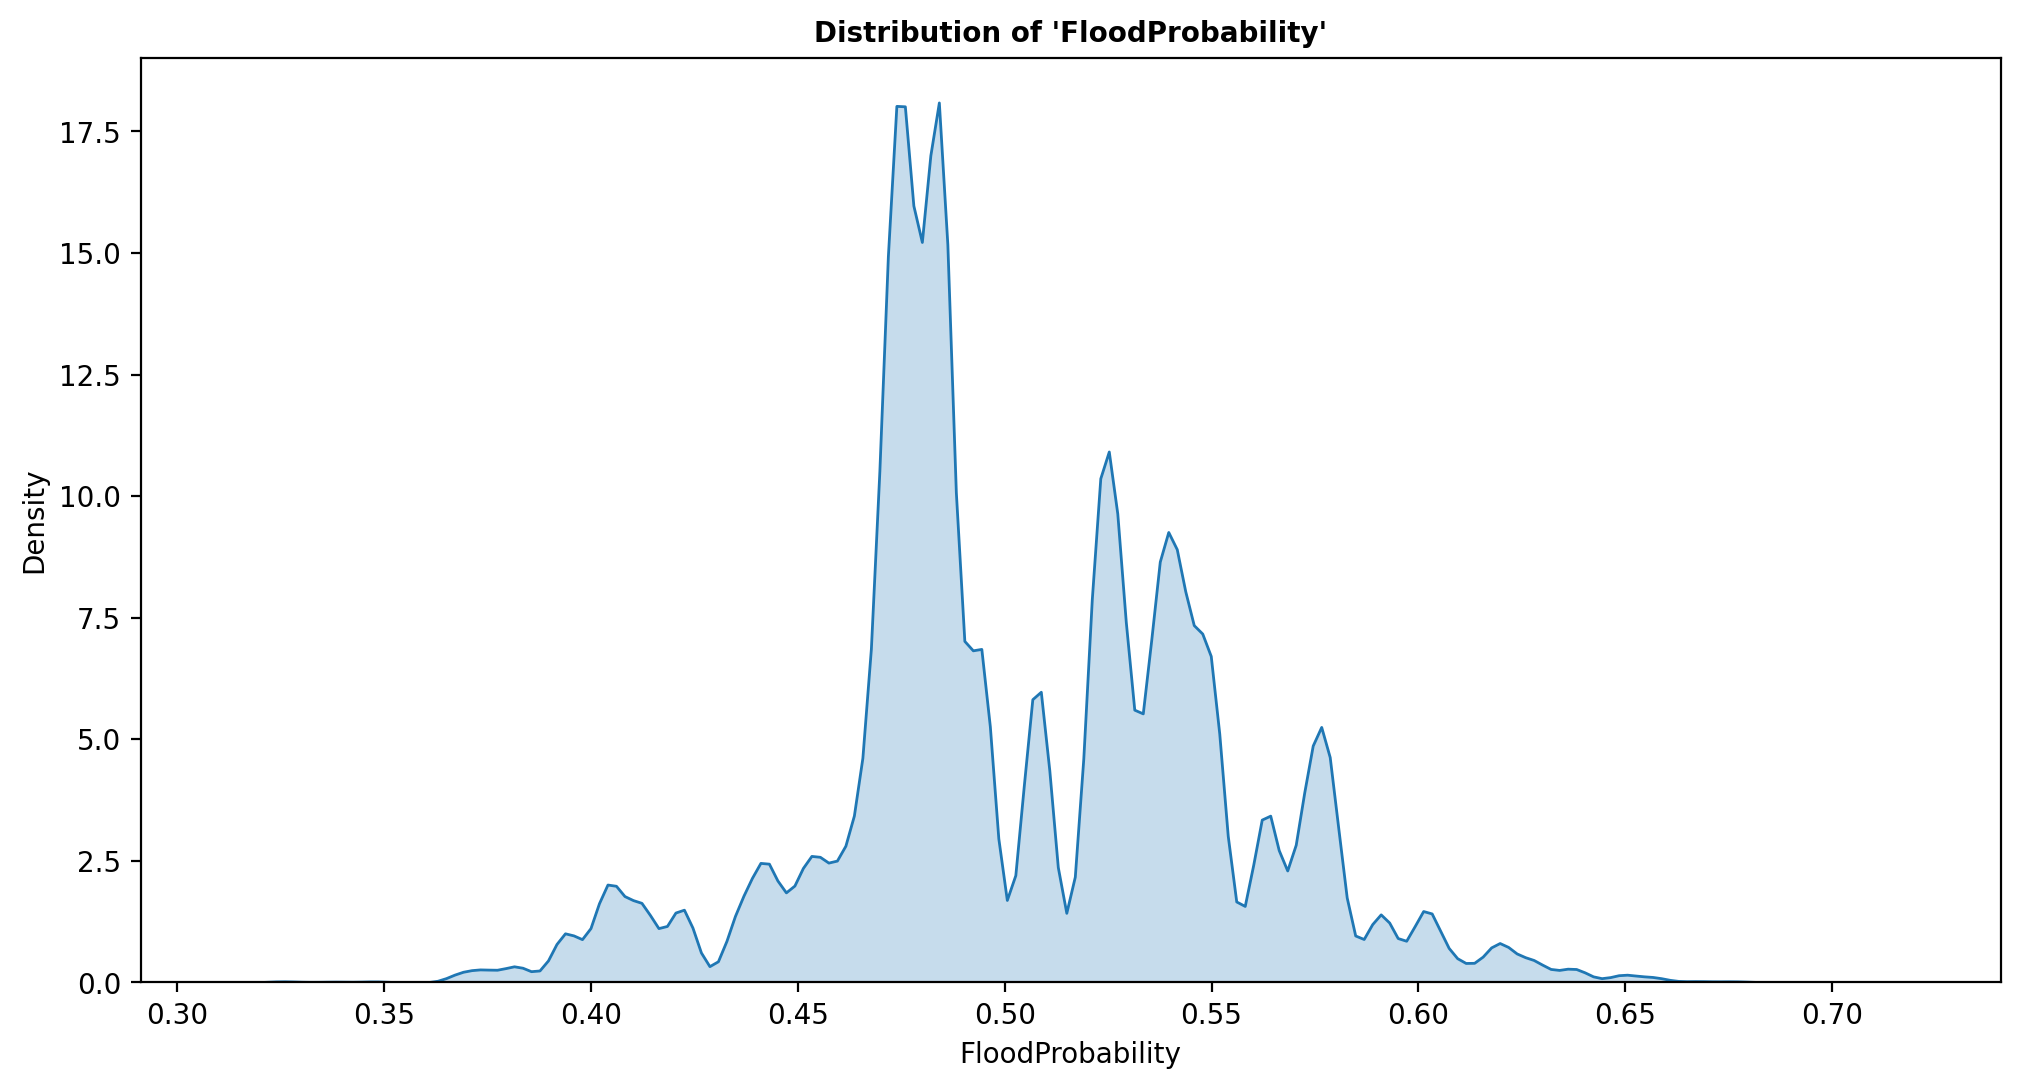

In [51]:
plt.figure(figsize = (12, 6), dpi = 200)
sns.kdeplot(sample_submission.FloodProbability, fill = True)
plt.title("Distribution of 'FloodProbability'", weight = 'bold', size = 10)
plt.show()